This project attempts to predict the time required for a New York City taxi to travel from one location to another based on data available from previous trips. This project utilizes a large data set which is available on Kaggle as this is an active competition. 

In [23]:
#import training data
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames - required if code is run on Python 2.7
training_data_2 = pd.read_csv('train.csv')
display(training_data_2.head())
print('Training data shape: ', training_data_2.shape)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Training data shape:  (1458644, 11)


Multiple data columns can be derived from pick up date time.
1. Week day for pick up
2. Hour of the day for pick up

In [24]:
#function to determine day of the week
import time
time_format = '%Y-%m-%d %H:%M:%S'
def get_weekday(date_str):
    time_obj = time.strptime(date_str,time_format)
    return time_obj.tm_wday

training_data_2['pickup_weekday'] = [get_weekday(date_str) for date_str in training_data_2['pickup_datetime']]

#get pick up hour
def get_hour(date_str):
    time_obj = time.strptime(date_str,time_format)
    return time_obj.tm_hour

training_data_2['pickup_hour'] = [get_hour(date_str) for date_str in training_data_2['pickup_datetime']]

display(training_data_2.head())
print('Training data shape: ', training_data_2.shape)



,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,13


Training data shape:  (1458644, 13)


Convert time to float to make it usable in model training. Using math and time libraries by using the following steps:
1. Convert pickup_datetime to a time object using the time.mktime function
2. This converted value is very large hence taking the natural log of the same to use it in a regressor function.

In [25]:
#convert pick up date to float to make it usable in model training
import math
training_data_2['pickup_datetime_float'] = [math.log(time.mktime(time.strptime(d,time_format))) 
                                    for d in training_data_2['pickup_datetime']]
display(training_data_2.head())
print('Training data shape: ', training_data_2.shape)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_hour,pickup_datetime_float
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,17,21.100283
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,0,21.105564
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,11,21.097004
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,19,21.101653
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,13,21.100984


Training data shape:  (1458644, 14)


Encode the store and forward flag to use it for model training

In [26]:
#one hot encode stoare and fwd flag
import numpy as np
print(training_data_2.store_and_fwd_flag.unique())
training_data_2['store_and_fwd_flag_encode'] = np.where(training_data_2['store_and_fwd_flag'].str.match('Y'),1,0)
display(training_data_2.head())
print('Training data shape: ', training_data_2.shape)

['N' 'Y']


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_hour,pickup_datetime_float,store_and_fwd_flag_encode
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,17,21.100283,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,0,21.105564,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,11,21.097004,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,19,21.101653,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,13,21.100984,0


Training data shape:  (1458644, 15)


Convert time in seconds to hours. This is to derive speed from the available data

In [27]:
#converting trip duration to hours for calculation ease
training_data_2['trip_duration_hrs'] = [duration_in_seconds/3600.0 for duration_in_seconds in 
                                          training_data_2['trip_duration']]
display(training_data_2.head())
print('Training data shape: ', training_data_2.shape)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_hour,pickup_datetime_float,store_and_fwd_flag_encode,trip_duration_hrs
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,17,21.100283,0,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,0,21.105564,0,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,11,21.097004,0,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,19,21.101653,0,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,13,21.100984,0,0.120833


Training data shape:  (1458644, 16)


Derive the displacement from latitude and longitude difference and speed is derived using trip duration in hours

In [28]:
#calculate latitude difference, longitude difference and speed for analysis
import math
training_data_2['latitude_difference'] = [dropoff_val-pickup_val for pickup_val, dropoff_val in 
                                            zip(training_data_2['pickup_latitude'], training_data_2['dropoff_latitude'])]
training_data_2['longitude_difference'] = [dropoff_val-pickup_val for pickup_val, dropoff_val in 
                                            zip(training_data_2['pickup_longitude'], training_data_2['dropoff_longitude'])]
training_data_2['displacement'] = [math.sqrt(math.pow(lat_diff,2)+math.pow(long_diff,2)) for lat_diff, long_diff in 
                                            zip(training_data_2['latitude_difference'], 
                                                training_data_2['longitude_difference'])]
#speed feature needs to be dropped before training as this feature cannot be derived for testing data
#this feature is used only for analysis only as trip duration will depend on the speed of travel
training_data_2['speed'] = [dist/timee for dist, timee in zip(training_data_2['displacement'], 
                                                                training_data_2['trip_duration_hrs'])]
display(training_data_2.head())
print('Training data shape: ', training_data_2.shape)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_hour,pickup_datetime_float,store_and_fwd_flag_encode,trip_duration_hrs,latitude_difference,longitude_difference,displacement,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,17,21.100283,0,0.126389,-0.002335,0.017525,0.017680,0.139882
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,0,21.105564,0,0.184167,-0.007412,-0.019066,0.020456,0.111073
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,11,21.097004,0,0.590000,-0.053852,-0.026306,0.059934,0.101583
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,19,21.101653,0,0.119167,-0.013252,-0.002228,0.013438,0.112768
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,13,21.100984,0,0.120833,-0.010689,0.000130,0.010690,0.088465


Training data shape:  (1458644, 20)


Plot the available data for data analysis and visualization

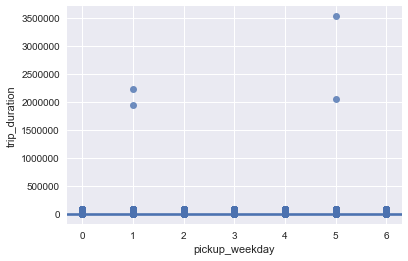

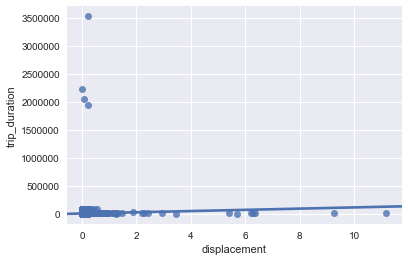

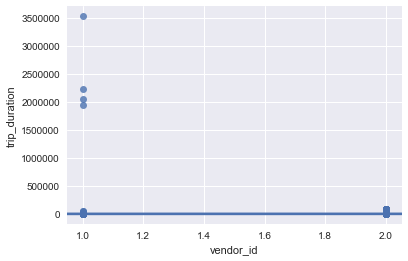

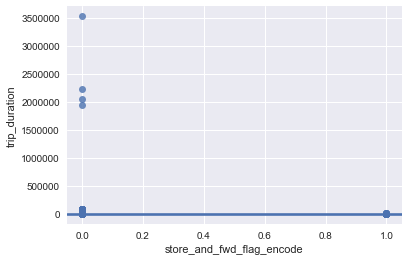

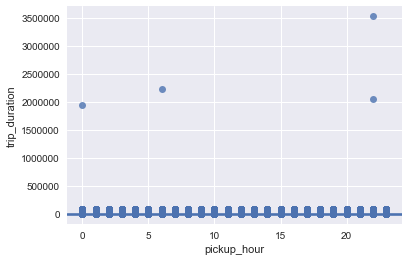

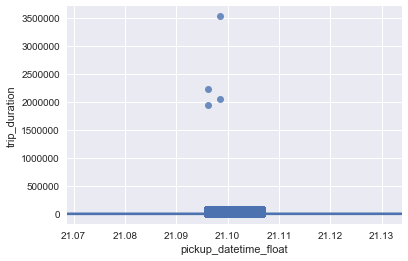

In [8]:
#plot of available data
import matplotlib.pyplot as plt
#using seaborn to plot because of large dataset
import seaborn as sns
%matplotlib inline
sns.regplot(training_data_2['pickup_weekday'], training_data_2['trip_duration'])
plt.show()
sns.regplot(training_data_2['displacement'], training_data_2['trip_duration'])
plt.show()
sns.regplot(training_data_2['vendor_id'], training_data_2['trip_duration'])
plt.show()
sns.regplot(training_data_2['store_and_fwd_flag_encode'], training_data_2['trip_duration'])
plt.show()
sns.regplot(training_data_2['pickup_hour'], training_data_2['trip_duration'])
plt.show()
sns.regplot(training_data_2['pickup_datetime_float'], training_data_2['trip_duration'])
plt.show()

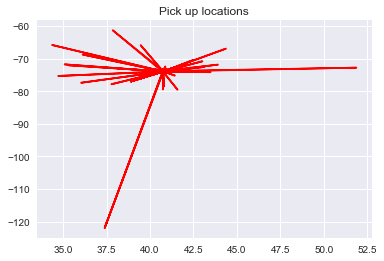

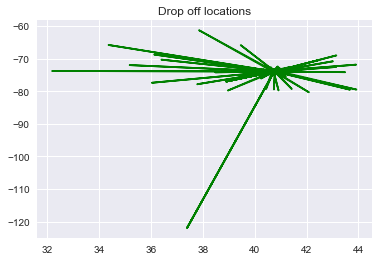

In [9]:
plt.plot(training_data_2['pickup_latitude'], training_data_2['pickup_longitude'],'r')
plt.title('Pick up locations')
plt.show()
plt.plot(training_data_2['dropoff_latitude'], training_data_2['dropoff_longitude'],'g')
plt.title('Drop off locations')
plt.show()

As seen from the graphs above any models created for this data can get skewed because of the outliers present. Performing outlier analysis to eliminate outlier data.

In [29]:
#eliminate outliers for the data for clean data and better visualization
outlier_array_list = []
for key in training_data_2:
    #restricting the anaylysis to trip duration - 10K rows eliminated
    #restricting the analysis to speed - 3K rows eliminated
    #extend this to all features id necessary
    if training_data_2[key].dtypes == 'float64' or key =='trip_duration':
        print('Analysis for ', key)
        Q1 = np.percentile(training_data_2[key], 25)
        print('Q1 ', Q1)
        Q3 = np.percentile(training_data_2[key], 75)
        print('Q3 ', Q3)
        interquartile_range = Q3-Q1
        step = 1.5*interquartile_range
        print('step ', step)
        print ("Data points considered outliers for the feature :", key)
        display(training_data_2[~((training_data_2[key] >= Q1 - step) & (training_data_2[key] <= Q3 + step))])
        #additional code to eliminate all outliers
        outlier_array = (np.where([~((training_data_2[key] >= Q1 - step) & (training_data_2[key] <= Q3 + step))]))
        print(outlier_array[1])
        for outlier in outlier_array[1]:
            outlier_array_list.append(outlier)
        
outliers = list(set(outlier_array_list))
good_data = training_data_2.drop(training_data_2.index[outliers]).reset_index(drop = True)
display(good_data.head())
print(good_data.shape)

Analysis for  pickup_longitude
Q1  -73.9918670654
Q3  -73.9673309326
step  0.0368041992188
Data points considered outliers for the feature : pickup_longitude


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_hour,pickup_datetime_float,store_and_fwd_flag_encode,trip_duration_hrs,latitude_difference,longitude_difference,displacement,speed
55,id3827863,2,2016-04-19 11:29:08,2016-04-19 12:27:56,3,-73.792892,40.657879,-73.809189,40.690182,N,3528,1,11,21.102402,0,0.980000,0.032303,-0.016296,0.036181,0.036919
70,id3896508,2,2016-06-07 22:32:32,2016-06-07 22:46:06,1,-73.863380,40.769890,-73.837128,40.721359,N,814,1,22,21.105323,0,0.226111,-0.048531,0.026253,0.055176,0.244023
86,id0283075,1,2016-04-06 23:42:26,2016-04-07 00:12:08,1,-73.782478,40.644646,-73.981125,40.720886,N,1782,2,23,21.101663,0,0.495000,0.076241,-0.198647,0.212775,0.429848
93,id2030290,1,2016-03-31 11:33:30,2016-03-31 12:12:31,3,-73.864319,40.769829,-73.985863,40.760952,N,2341,3,11,21.101276,0,0.650278,-0.008877,-0.121544,0.121868,0.187409
98,id2102594,1,2016-03-30 16:14:29,2016-03-30 17:01:33,1,-73.789841,40.643559,-73.970665,40.687279,N,2824,2,16,21.101228,0,0.784444,0.043720,-0.180824,0.186035,0.237155
102,id0105610,1,2016-02-19 20:01:24,2016-02-19 20:35:49,3,-73.789719,40.643707,-73.978699,40.750343,N,2065,4,20,21.098866,0,0.573611,0.106636,-0.188980,0.216990,0.378288
104,id3508035,2,2016-06-06 20:13:56,2016-06-06 20:45:20,6,-73.788132,40.641460,-73.971771,40.749409,N,1884,0,20,21.105258,0,0.523333,0.107948,-0.183640,0.213017,0.407039
111,id0589360,1,2016-05-22 17:34:08,2016-05-22 18:20:01,1,-73.863678,40.769772,-74.007217,40.704895,N,2753,6,17,21.104367,0,0.764722,-0.064877,-0.143539,0.157520,0.205983
115,id2358953,2,2016-06-27 00:31:28,2016-06-27 01:06:44,1,-73.870819,40.773739,-73.857498,41.017811,N,2116,0,0,21.106447,0,0.587778,0.244072,0.013321,0.244435,0.415863
198,id3942917,1,2016-04-29 14:18:39,2016-04-29 15:05:36,4,-73.862778,40.769314,-73.986130,40.748581,N,2817,4,14,21.103000,0,0.782500,-0.020733,-0.123352,0.125082,0.159850


[     55      70      86 ..., 1458590 1458600 1458636]
Analysis for  pickup_latitude
Q1  40.7373466492
Q3  40.7683601379
step  0.0465202331543
Data points considered outliers for the feature : pickup_latitude


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_hour,pickup_datetime_float,store_and_fwd_flag_encode,trip_duration_hrs,latitude_difference,longitude_difference,displacement,speed
55,id3827863,2,2016-04-19 11:29:08,2016-04-19 12:27:56,3,-73.792892,40.657879,-73.809189,40.690182,N,3528,1,11,21.102402,0,0.980000,0.032303,-0.016296,0.036181,0.036919
86,id0283075,1,2016-04-06 23:42:26,2016-04-07 00:12:08,1,-73.782478,40.644646,-73.981125,40.720886,N,1782,2,23,21.101663,0,0.495000,0.076241,-0.198647,0.212775,0.429848
98,id2102594,1,2016-03-30 16:14:29,2016-03-30 17:01:33,1,-73.789841,40.643559,-73.970665,40.687279,N,2824,2,16,21.101228,0,0.784444,0.043720,-0.180824,0.186035,0.237155
102,id0105610,1,2016-02-19 20:01:24,2016-02-19 20:35:49,3,-73.789719,40.643707,-73.978699,40.750343,N,2065,4,20,21.098866,0,0.573611,0.106636,-0.188980,0.216990,0.378288
104,id3508035,2,2016-06-06 20:13:56,2016-06-06 20:45:20,6,-73.788132,40.641460,-73.971771,40.749409,N,1884,0,20,21.105258,0,0.523333,0.107948,-0.183640,0.213017,0.407039
231,id1868620,2,2016-06-18 00:41:28,2016-06-18 01:10:34,1,-73.781860,40.644684,-73.961922,40.767033,N,1746,5,0,21.105918,0,0.485000,0.122349,-0.180061,0.217695,0.448857
233,id0952827,2,2016-03-25 00:22:07,2016-03-25 00:36:20,1,-73.998062,40.674809,-74.004440,40.732651,N,853,4,0,21.100893,0,0.236944,0.057842,-0.006378,0.058193,0.245597
268,id1636593,2,2016-04-25 17:37:13,2016-04-25 18:23:12,1,-73.790154,40.646614,-73.981918,40.756680,N,2759,0,17,21.102772,0,0.766389,0.110065,-0.191765,0.221107,0.288505
319,id1703171,2,2016-01-30 22:42:51,2016-01-30 23:23:44,5,-73.786217,40.645287,-73.993073,40.729729,N,2453,5,22,21.097685,0,0.681389,0.084442,-0.206856,0.223427,0.327900
354,id3402983,2,2016-06-30 15:48:06,2016-06-30 17:31:13,1,-73.781898,40.644772,-73.985893,40.760159,N,6187,3,15,21.106662,0,1.718611,0.115387,-0.203995,0.234367,0.136370


[     55      86      98 ..., 1458584 1458589 1458600]
Analysis for  dropoff_longitude
Q1  -73.9913253784
Q3  -73.9630126953
step  0.0424690246582
Data points considered outliers for the feature : dropoff_longitude


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_hour,pickup_datetime_float,store_and_fwd_flag_encode,trip_duration_hrs,latitude_difference,longitude_difference,displacement,speed
24,id3321406,2,2016-06-03 08:15:05,2016-06-03 08:56:30,1,-73.955231,40.777134,-73.788750,40.641472,N,2485,4,8,21.105052,0,0.690278,-0.135662,0.166481,0.214756,0.311115
29,id1410897,1,2016-03-23 14:10:39,2016-03-23 14:49:30,1,-73.982117,40.756351,-73.865692,40.770988,N,2331,2,14,21.100808,0,0.647500,0.014637,0.116425,0.117341,0.181222
33,id0023813,1,2016-04-17 14:38:30,2016-04-17 15:16:19,1,-73.990311,40.756580,-73.870918,40.773930,N,2269,6,14,21.102292,0,0.630278,0.017349,0.119392,0.120646,0.191418
50,id2067879,2,2016-01-19 23:19:01,2016-01-19 23:44:58,1,-73.996819,40.752861,-73.809006,40.816875,N,1557,1,23,21.097033,0,0.432500,0.064014,0.187813,0.198423,0.458780
55,id3827863,2,2016-04-19 11:29:08,2016-04-19 12:27:56,3,-73.792892,40.657879,-73.809189,40.690182,N,3528,1,11,21.102402,0,0.980000,0.032303,-0.016296,0.036181,0.036919
70,id3896508,2,2016-06-07 22:32:32,2016-06-07 22:46:06,1,-73.863380,40.769890,-73.837128,40.721359,N,814,1,22,21.105323,0,0.226111,-0.048531,0.026253,0.055176,0.244023
74,id1158195,1,2016-03-24 17:58:51,2016-03-24 18:36:46,1,-73.992325,40.730721,-73.872505,40.774498,N,2275,3,17,21.100877,0,0.631944,0.043777,0.119820,0.127567,0.201863
92,id0673727,2,2016-05-18 19:15:27,2016-05-18 19:44:49,1,-73.961678,40.775967,-73.857391,40.733284,N,1762,2,19,21.104135,0,0.489444,-0.042683,0.104286,0.112683,0.230226
115,id2358953,2,2016-06-27 00:31:28,2016-06-27 01:06:44,1,-73.870819,40.773739,-73.857498,41.017811,N,2116,0,0,21.106447,0,0.587778,0.244072,0.013321,0.244435,0.415863
137,id0659170,2,2016-03-26 13:07:08,2016-03-26 13:29:02,1,-73.968658,40.764507,-73.872833,40.771454,N,1314,5,13,21.100983,0,0.365000,0.006947,0.095825,0.096077,0.263224


[     24      29      33 ..., 1458547 1458589 1458636]
Analysis for  dropoff_latitude
Q1  40.7358846664
Q3  40.7698097229
step  0.0508875846863
Data points considered outliers for the feature : dropoff_latitude


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_hour,pickup_datetime_float,store_and_fwd_flag_encode,trip_duration_hrs,latitude_difference,longitude_difference,displacement,speed
24,id3321406,2,2016-06-03 08:15:05,2016-06-03 08:56:30,1,-73.955231,40.777134,-73.788750,40.641472,N,2485,4,8,21.105052,0,0.690278,-0.135662,0.166481,0.214756,0.311115
27,id2104175,1,2016-06-20 23:07:16,2016-06-20 23:18:50,1,-73.958435,40.713192,-73.949539,40.680252,N,694,0,23,21.106090,0,0.192778,-0.032940,0.008896,0.034120,0.176991
31,id2822549,2,2016-05-21 13:03:24,2016-05-21 13:20:52,1,-73.998268,40.720039,-74.010361,40.672138,N,1048,5,13,21.104297,0,0.291111,-0.047901,-0.012093,0.049404,0.169708
67,id3913101,1,2016-06-25 22:05:46,2016-06-25 22:22:29,2,-74.001411,40.761433,-73.924629,40.864029,N,1003,5,22,21.106382,0,0.278611,0.102596,0.076782,0.128146,0.459947
115,id2358953,2,2016-06-27 00:31:28,2016-06-27 01:06:44,1,-73.870819,40.773739,-73.857498,41.017811,N,2116,0,0,21.106447,0,0.587778,0.244072,0.013321,0.244435,0.415863
167,id0906779,1,2016-04-19 08:31:48,2016-04-19 09:14:11,2,-73.971558,40.750629,-73.952629,40.631596,N,2543,1,8,21.102395,0,0.706389,-0.119034,0.018929,0.120529,0.170628
168,id2326430,2,2016-06-10 22:06:53,2016-06-10 22:23:14,1,-73.956879,40.774872,-73.936508,40.857185,N,981,4,22,21.105499,0,0.272500,0.082314,0.020370,0.084797,0.311180
185,id3198639,1,2016-06-05 03:02:46,2016-06-05 03:14:59,1,-73.979790,40.781265,-73.940880,40.823223,N,733,6,3,21.105157,0,0.203611,0.041958,0.038910,0.057223,0.281039
220,id2050990,2,2016-06-20 21:05:09,2016-06-20 21:47:45,1,-73.990082,40.756737,-73.955132,40.677525,N,2556,0,21,21.106085,0,0.710000,-0.079212,0.034950,0.086580,0.121944
266,id2693088,2,2016-04-23 23:28:09,2016-04-23 23:43:01,2,-73.975418,40.787075,-73.942657,40.823551,N,892,5,23,21.102668,0,0.247778,0.036476,0.032761,0.049028,0.197872


[     24      27      31 ..., 1458536 1458553 1458629]
Analysis for  trip_duration
Q1  397.0
Q3  1075.0
step  1017.0
Data points considered outliers for the feature : trip_duration


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_hour,pickup_datetime_float,store_and_fwd_flag_encode,trip_duration_hrs,latitude_difference,longitude_difference,displacement,speed
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,11,21.097004,0,0.590000,-0.053852,-0.026306,0.059934,0.101583
16,id3379579,2,2016-04-11 17:29:50,2016-04-11 18:08:26,1,-73.991165,40.755562,-73.999290,40.725353,N,2316,0,17,21.101944,0,0.643333,-0.030209,-0.008125,0.031282,0.048625
24,id3321406,2,2016-06-03 08:15:05,2016-06-03 08:56:30,1,-73.955231,40.777134,-73.788750,40.641472,N,2485,4,8,21.105052,0,0.690278,-0.135662,0.166481,0.214756,0.311115
29,id1410897,1,2016-03-23 14:10:39,2016-03-23 14:49:30,1,-73.982117,40.756351,-73.865692,40.770988,N,2331,2,14,21.100808,0,0.647500,0.014637,0.116425,0.117341,0.181222
33,id0023813,1,2016-04-17 14:38:30,2016-04-17 15:16:19,1,-73.990311,40.756580,-73.870918,40.773930,N,2269,6,14,21.102292,0,0.630278,0.017349,0.119392,0.120646,0.191418
55,id3827863,2,2016-04-19 11:29:08,2016-04-19 12:27:56,3,-73.792892,40.657879,-73.809189,40.690182,N,3528,1,11,21.102402,0,0.980000,0.032303,-0.016296,0.036181,0.036919
57,id1079955,1,2016-04-22 11:28:00,2016-04-22 12:11:27,1,-73.994850,40.718781,-73.983414,40.758850,N,2607,4,11,21.102579,0,0.724167,0.040070,0.011436,0.041670,0.057542
74,id1158195,1,2016-03-24 17:58:51,2016-03-24 18:36:46,1,-73.992325,40.730721,-73.872505,40.774498,N,2275,3,17,21.100877,0,0.631944,0.043777,0.119820,0.127567,0.201863
77,id3769871,1,2016-06-17 17:32:59,2016-06-17 18:11:56,1,-73.943146,40.789631,-73.989479,40.762764,N,2337,4,17,21.105900,0,0.649167,-0.026867,-0.046333,0.053559,0.082505
93,id2030290,1,2016-03-31 11:33:30,2016-03-31 12:12:31,3,-73.864319,40.769829,-73.985863,40.760952,N,2341,3,11,21.101276,0,0.650278,-0.008877,-0.121544,0.121868,0.187409


[      2      16      24 ..., 1458589 1458600 1458621]
Analysis for  pickup_datetime_float
Q1  21.0987395074
Q3  21.1039199274
step  0.00777063011344
Data points considered outliers for the feature : pickup_datetime_float


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_hour,pickup_datetime_float,store_and_fwd_flag_encode,trip_duration_hrs,latitude_difference,longitude_difference,displacement,speed


[]
Analysis for  trip_duration_hrs
Q1  0.110277777778
Q3  0.298611111111
step  0.2825
Data points considered outliers for the feature : trip_duration_hrs


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_hour,pickup_datetime_float,store_and_fwd_flag_encode,trip_duration_hrs,latitude_difference,longitude_difference,displacement,speed
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,11,21.097004,0,0.590000,-0.053852,-0.026306,0.059934,0.101583
16,id3379579,2,2016-04-11 17:29:50,2016-04-11 18:08:26,1,-73.991165,40.755562,-73.999290,40.725353,N,2316,0,17,21.101944,0,0.643333,-0.030209,-0.008125,0.031282,0.048625
24,id3321406,2,2016-06-03 08:15:05,2016-06-03 08:56:30,1,-73.955231,40.777134,-73.788750,40.641472,N,2485,4,8,21.105052,0,0.690278,-0.135662,0.166481,0.214756,0.311115
29,id1410897,1,2016-03-23 14:10:39,2016-03-23 14:49:30,1,-73.982117,40.756351,-73.865692,40.770988,N,2331,2,14,21.100808,0,0.647500,0.014637,0.116425,0.117341,0.181222
33,id0023813,1,2016-04-17 14:38:30,2016-04-17 15:16:19,1,-73.990311,40.756580,-73.870918,40.773930,N,2269,6,14,21.102292,0,0.630278,0.017349,0.119392,0.120646,0.191418
55,id3827863,2,2016-04-19 11:29:08,2016-04-19 12:27:56,3,-73.792892,40.657879,-73.809189,40.690182,N,3528,1,11,21.102402,0,0.980000,0.032303,-0.016296,0.036181,0.036919
57,id1079955,1,2016-04-22 11:28:00,2016-04-22 12:11:27,1,-73.994850,40.718781,-73.983414,40.758850,N,2607,4,11,21.102579,0,0.724167,0.040070,0.011436,0.041670,0.057542
74,id1158195,1,2016-03-24 17:58:51,2016-03-24 18:36:46,1,-73.992325,40.730721,-73.872505,40.774498,N,2275,3,17,21.100877,0,0.631944,0.043777,0.119820,0.127567,0.201863
77,id3769871,1,2016-06-17 17:32:59,2016-06-17 18:11:56,1,-73.943146,40.789631,-73.989479,40.762764,N,2337,4,17,21.105900,0,0.649167,-0.026867,-0.046333,0.053559,0.082505
93,id2030290,1,2016-03-31 11:33:30,2016-03-31 12:12:31,3,-73.864319,40.769829,-73.985863,40.760952,N,2341,3,11,21.101276,0,0.650278,-0.008877,-0.121544,0.121868,0.187409


[      2      16      24 ..., 1458589 1458600 1458621]
Analysis for  latitude_difference
Q1  -0.0134201049805
Q3  0.0139923095703
step  0.0411186218262
Data points considered outliers for the feature : latitude_difference


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_hour,pickup_datetime_float,store_and_fwd_flag_encode,trip_duration_hrs,latitude_difference,longitude_difference,displacement,speed
14,id2900608,2,2016-05-27 00:43:36,2016-05-27 01:07:10,1,-73.992195,40.727226,-73.974655,40.783070,N,1414,4,0,21.104620,0,0.392778,0.055843,0.017540,0.058533,0.149024
24,id3321406,2,2016-06-03 08:15:05,2016-06-03 08:56:30,1,-73.955231,40.777134,-73.788750,40.641472,N,2485,4,8,21.105052,0,0.690278,-0.135662,0.166481,0.214756,0.311115
45,id0718344,2,2016-06-13 15:52:20,2016-06-13 16:16:58,1,-74.016327,40.704990,-73.982109,40.773750,N,1478,0,15,21.105660,0,0.410556,0.068760,0.034218,0.076804,0.187072
50,id2067879,2,2016-01-19 23:19:01,2016-01-19 23:44:58,1,-73.996819,40.752861,-73.809006,40.816875,N,1557,1,23,21.097033,0,0.432500,0.064014,0.187813,0.198423,0.458780
54,id0526266,2,2016-05-15 09:42:58,2016-05-15 09:56:37,1,-73.934883,40.801010,-73.983002,40.722569,N,819,6,9,21.103934,0,0.227500,-0.078442,-0.048119,0.092024,0.404503
67,id3913101,1,2016-06-25 22:05:46,2016-06-25 22:22:29,2,-74.001411,40.761433,-73.924629,40.864029,N,1003,5,22,21.106382,0,0.278611,0.102596,0.076782,0.128146,0.459947
86,id0283075,1,2016-04-06 23:42:26,2016-04-07 00:12:08,1,-73.782478,40.644646,-73.981125,40.720886,N,1782,2,23,21.101663,0,0.495000,0.076241,-0.198647,0.212775,0.429848
102,id0105610,1,2016-02-19 20:01:24,2016-02-19 20:35:49,3,-73.789719,40.643707,-73.978699,40.750343,N,2065,4,20,21.098866,0,0.573611,0.106636,-0.188980,0.216990,0.378288
104,id3508035,2,2016-06-06 20:13:56,2016-06-06 20:45:20,6,-73.788132,40.641460,-73.971771,40.749409,N,1884,0,20,21.105258,0,0.523333,0.107948,-0.183640,0.213017,0.407039
111,id0589360,1,2016-05-22 17:34:08,2016-05-22 18:20:01,1,-73.863678,40.769772,-74.007217,40.704895,N,2753,6,17,21.104367,0,0.764722,-0.064877,-0.143539,0.157520,0.205983


[     14      24      45 ..., 1458589 1458600 1458641]
Analysis for  longitude_difference
Q1  -0.0112686157227
Q3  0.0139389038086
step  0.0378112792969
Data points considered outliers for the feature : longitude_difference


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_hour,pickup_datetime_float,store_and_fwd_flag_encode,trip_duration_hrs,latitude_difference,longitude_difference,displacement,speed
24,id3321406,2,2016-06-03 08:15:05,2016-06-03 08:56:30,1,-73.955231,40.777134,-73.788750,40.641472,N,2485,4,8,21.105052,0,0.690278,-0.135662,0.166481,0.214756,0.311115
29,id1410897,1,2016-03-23 14:10:39,2016-03-23 14:49:30,1,-73.982117,40.756351,-73.865692,40.770988,N,2331,2,14,21.100808,0,0.647500,0.014637,0.116425,0.117341,0.181222
33,id0023813,1,2016-04-17 14:38:30,2016-04-17 15:16:19,1,-73.990311,40.756580,-73.870918,40.773930,N,2269,6,14,21.102292,0,0.630278,0.017349,0.119392,0.120646,0.191418
50,id2067879,2,2016-01-19 23:19:01,2016-01-19 23:44:58,1,-73.996819,40.752861,-73.809006,40.816875,N,1557,1,23,21.097033,0,0.432500,0.064014,0.187813,0.198423,0.458780
67,id3913101,1,2016-06-25 22:05:46,2016-06-25 22:22:29,2,-74.001411,40.761433,-73.924629,40.864029,N,1003,5,22,21.106382,0,0.278611,0.102596,0.076782,0.128146,0.459947
74,id1158195,1,2016-03-24 17:58:51,2016-03-24 18:36:46,1,-73.992325,40.730721,-73.872505,40.774498,N,2275,3,17,21.100877,0,0.631944,0.043777,0.119820,0.127567,0.201863
80,id1519515,2,2016-06-11 12:52:19,2016-06-11 13:12:10,1,-73.950493,40.771267,-74.001244,40.746490,N,1191,5,12,21.105535,0,0.330833,-0.024776,-0.050751,0.056476,0.170708
86,id0283075,1,2016-04-06 23:42:26,2016-04-07 00:12:08,1,-73.782478,40.644646,-73.981125,40.720886,N,1782,2,23,21.101663,0,0.495000,0.076241,-0.198647,0.212775,0.429848
92,id0673727,2,2016-05-18 19:15:27,2016-05-18 19:44:49,1,-73.961678,40.775967,-73.857391,40.733284,N,1762,2,19,21.104135,0,0.489444,-0.042683,0.104286,0.112683,0.230226
93,id2030290,1,2016-03-31 11:33:30,2016-03-31 12:12:31,3,-73.864319,40.769829,-73.985863,40.760952,N,2341,3,11,21.101276,0,0.650278,-0.008877,-0.121544,0.121868,0.187409


[     24      29      33 ..., 1458584 1458589 1458600]
Analysis for  displacement
Q1  0.0125844318865
Q3  0.038408844648
step  0.0387366191422
Data points considered outliers for the feature : displacement


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_hour,pickup_datetime_float,store_and_fwd_flag_encode,trip_duration_hrs,latitude_difference,longitude_difference,displacement,speed
24,id3321406,2,2016-06-03 08:15:05,2016-06-03 08:56:30,1,-73.955231,40.777134,-73.788750,40.641472,N,2485,4,8,21.105052,0,0.690278,-0.135662,0.166481,0.214756,0.311115
29,id1410897,1,2016-03-23 14:10:39,2016-03-23 14:49:30,1,-73.982117,40.756351,-73.865692,40.770988,N,2331,2,14,21.100808,0,0.647500,0.014637,0.116425,0.117341,0.181222
33,id0023813,1,2016-04-17 14:38:30,2016-04-17 15:16:19,1,-73.990311,40.756580,-73.870918,40.773930,N,2269,6,14,21.102292,0,0.630278,0.017349,0.119392,0.120646,0.191418
50,id2067879,2,2016-01-19 23:19:01,2016-01-19 23:44:58,1,-73.996819,40.752861,-73.809006,40.816875,N,1557,1,23,21.097033,0,0.432500,0.064014,0.187813,0.198423,0.458780
54,id0526266,2,2016-05-15 09:42:58,2016-05-15 09:56:37,1,-73.934883,40.801010,-73.983002,40.722569,N,819,6,9,21.103934,0,0.227500,-0.078442,-0.048119,0.092024,0.404503
67,id3913101,1,2016-06-25 22:05:46,2016-06-25 22:22:29,2,-74.001411,40.761433,-73.924629,40.864029,N,1003,5,22,21.106382,0,0.278611,0.102596,0.076782,0.128146,0.459947
74,id1158195,1,2016-03-24 17:58:51,2016-03-24 18:36:46,1,-73.992325,40.730721,-73.872505,40.774498,N,2275,3,17,21.100877,0,0.631944,0.043777,0.119820,0.127567,0.201863
86,id0283075,1,2016-04-06 23:42:26,2016-04-07 00:12:08,1,-73.782478,40.644646,-73.981125,40.720886,N,1782,2,23,21.101663,0,0.495000,0.076241,-0.198647,0.212775,0.429848
92,id0673727,2,2016-05-18 19:15:27,2016-05-18 19:44:49,1,-73.961678,40.775967,-73.857391,40.733284,N,1762,2,19,21.104135,0,0.489444,-0.042683,0.104286,0.112683,0.230226
93,id2030290,1,2016-03-31 11:33:30,2016-03-31 12:12:31,3,-73.864319,40.769829,-73.985863,40.760952,N,2341,3,11,21.101276,0,0.650278,-0.008877,-0.121544,0.121868,0.187409


[     24      29      33 ..., 1458584 1458589 1458600]
Analysis for  speed
Q1  0.09280532228
Q3  0.179816523801
step  0.130516802281
Data points considered outliers for the feature : speed


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_hour,pickup_datetime_float,store_and_fwd_flag_encode,trip_duration_hrs,latitude_difference,longitude_difference,displacement,speed
24,id3321406,2,2016-06-03 08:15:05,2016-06-03 08:56:30,1,-73.955231,40.777134,-73.788750,40.641472,N,2485,4,8,21.105052,0,0.690278,-0.135662,0.166481,0.214756,0.311115
50,id2067879,2,2016-01-19 23:19:01,2016-01-19 23:44:58,1,-73.996819,40.752861,-73.809006,40.816875,N,1557,1,23,21.097033,0,0.432500,0.064014,0.187813,0.198423,0.458780
54,id0526266,2,2016-05-15 09:42:58,2016-05-15 09:56:37,1,-73.934883,40.801010,-73.983002,40.722569,N,819,6,9,21.103934,0,0.227500,-0.078442,-0.048119,0.092024,0.404503
67,id3913101,1,2016-06-25 22:05:46,2016-06-25 22:22:29,2,-74.001411,40.761433,-73.924629,40.864029,N,1003,5,22,21.106382,0,0.278611,0.102596,0.076782,0.128146,0.459947
86,id0283075,1,2016-04-06 23:42:26,2016-04-07 00:12:08,1,-73.782478,40.644646,-73.981125,40.720886,N,1782,2,23,21.101663,0,0.495000,0.076241,-0.198647,0.212775,0.429848
102,id0105610,1,2016-02-19 20:01:24,2016-02-19 20:35:49,3,-73.789719,40.643707,-73.978699,40.750343,N,2065,4,20,21.098866,0,0.573611,0.106636,-0.188980,0.216990,0.378288
104,id3508035,2,2016-06-06 20:13:56,2016-06-06 20:45:20,6,-73.788132,40.641460,-73.971771,40.749409,N,1884,0,20,21.105258,0,0.523333,0.107948,-0.183640,0.213017,0.407039
113,id0694434,1,2016-01-26 23:40:14,2016-01-26 23:48:39,1,-74.006798,40.706074,-73.974022,40.744076,N,505,1,23,21.097450,0,0.140278,0.038002,0.032776,0.050184,0.357746
115,id2358953,2,2016-06-27 00:31:28,2016-06-27 01:06:44,1,-73.870819,40.773739,-73.857498,41.017811,N,2116,0,0,21.106447,0,0.587778,0.244072,0.013321,0.244435,0.415863
149,id1630509,2,2016-03-16 05:42:49,2016-03-16 05:45:10,2,-73.993668,40.741879,-73.984589,40.754299,N,141,2,5,21.100373,0,0.039167,0.012421,0.009079,0.015385,0.392810


[     24      50      54 ..., 1458584 1458640 1458641]


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_hour,pickup_datetime_float,store_and_fwd_flag_encode,trip_duration_hrs,latitude_difference,longitude_difference,displacement,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,17,21.100283,0,0.126389,-0.002335,0.017525,0.017680,0.139882
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,0,21.105564,0,0.184167,-0.007412,-0.019066,0.020456,0.111073
2,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,19,21.101653,0,0.119167,-0.013252,-0.002228,0.013438,0.112768
3,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,13,21.100984,0,0.120833,-0.010689,0.000130,0.010690,0.088465
4,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443,5,22,21.097684,0,0.123056,0.006989,-0.009224,0.011572,0.094042


(1192409, 20)


Plotting graphs on good data

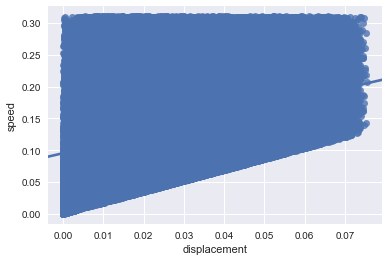

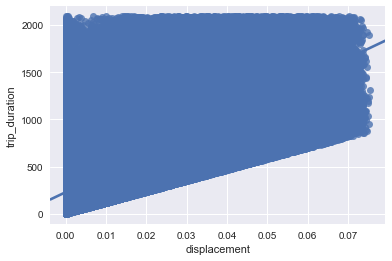

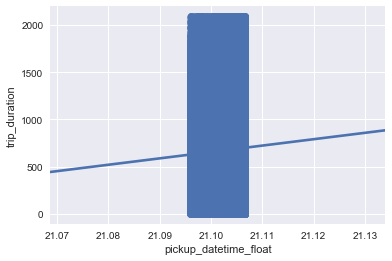

OverflowError: In draw_path: Exceeded cell block limit

OverflowError: In draw_path: Exceeded cell block limit

In [11]:
sns.regplot(good_data['displacement'], good_data['speed'])
plt.show()
sns.regplot(good_data['displacement'], good_data['trip_duration'])
plt.show()
sns.regplot(good_data['pickup_datetime_float'], good_data['trip_duration'])
plt.show()
plt.plot(good_data['pickup_latitude'], good_data['pickup_longitude'],'r')
plt.title('Pick up locations')
plt.show()
plt.plot(good_data['dropoff_latitude'], good_data['dropoff_longitude'],'g')
plt.title('Drop off locations')
plt.show()

Separate features and labels and eliminate features which potentially will not be used

In [30]:
#separate labels and eliminate un-necessary columns from training data
trip_time = good_data['trip_duration']
display(trip_time.head())
#also keeping converted data in hours to check if it makes a difference on training accuracy
trip_time_hrs = good_data['trip_duration_hrs']
display(trip_time_hrs.head())
#drop unnecessary columns
good_data.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag', 'trip_duration', 
                'trip_duration_hrs', 'speed'], axis=1, inplace=True)
display(good_data.head())
print(good_data.shape)

0    455
1    663
2    429
3    435
4    443
Name: trip_duration, dtype: int64

0    0.126389
1    0.184167
2    0.119167
3    0.120833
4    0.123056
Name: trip_duration_hrs, dtype: float64

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_weekday,pickup_hour,pickup_datetime_float,store_and_fwd_flag_encode,latitude_difference,longitude_difference,displacement
0,2,1,-73.982155,40.767937,-73.964630,40.765602,0,17,21.100283,0,-0.002335,0.017525,0.017680
1,1,1,-73.980415,40.738564,-73.999481,40.731152,6,0,21.105564,0,-0.007412,-0.019066,0.020456
2,2,1,-74.010040,40.719971,-74.012268,40.706718,2,19,21.101653,0,-0.013252,-0.002228,0.013438
3,2,1,-73.973053,40.793209,-73.972923,40.782520,5,13,21.100984,0,-0.010689,0.000130,0.010690
4,2,6,-73.982857,40.742195,-73.992081,40.749184,5,22,21.097684,0,0.006989,-0.009224,0.011572


(1192409, 13)


Parform Principal Component Analysis on good data to eliminate any features which may not influence the trip duration

shape of reduced data:  (1192409, 6)


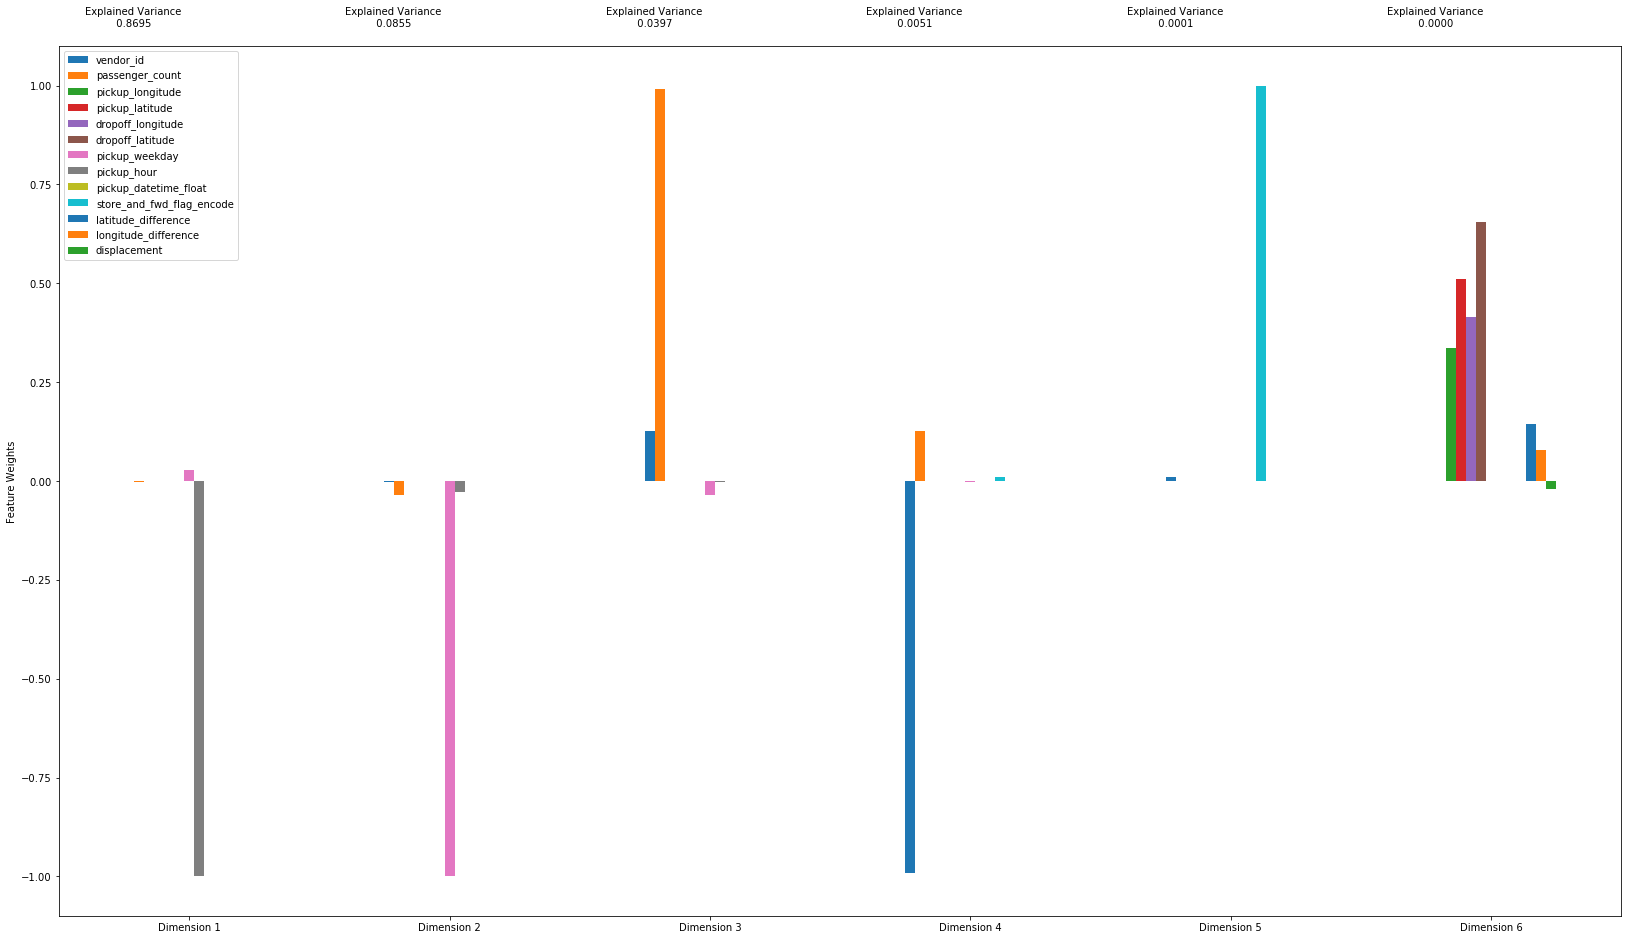

In [31]:
#PCA on good data
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
%matplotlib inline

def pca_results(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (28,16))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

#PCA
pca_comp = 6
from sklearn.decomposition import PCA
pca = PCA(n_components = pca_comp)
reduced_data = pca.fit_transform(good_data)
pca_bo_results = pca_results(good_data, pca)
print('shape of reduced data: ', reduced_data.shape)

Eliminate columns based on PCA

In [32]:
#based on pca analysis, reducing features by dropping pick up and drop off latitude and longitude and vendor id
good_data.drop(['vendor_id', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], 
               axis=1, inplace=True)

Split training and testing data using train test split function

In [33]:
#split data into training and testing sets
from sklearn.cross_validation import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(good_data, trip_time, test_size=0.2, random_state=0)
#predictions based on trip_time_hrs
X_train, X_test, y_train, y_test = train_test_split(good_data, trip_time_hrs, test_size=0.2, random_state=0)

Define utility functions for performance metric

In [34]:
#Define performance metrices
#define r2 performance metric
from sklearn.metrics import r2_score
def r2_performance_metric(y_true, y_predict):
    '''This function defines the performce metric based on the r2 score'''
    return r2_score(y_true, y_predict, multioutput = None)

#define rmsle performance metric
import math
def rmsle_score(y_true, y_pred):
    a = [math.log(val+1) for val in y_true if val >= 0]
    p = [math.log(val+1) for val in y_pred if val >= 0]
    squared_error = [math.pow(p_val-a_val,2) for p_val, a_val in zip(p, a)]
    mean_squared_error = np.mean(squared_error)
    return math.sqrt(mean_squared_error)

#unit tests
print(rmsle_score([1,1], [0,0]))
print(rmsle_score([1,1], [1,1]))
print(rmsle_score([2,2], [0,0]))
print(rmsle_score([-2,2], [0,0]))

0.6931471805599453
0.0
1.0986122886681098
1.0986122886681098


Define utility method to train and test the model

In [35]:
#Define accuracy for a given regressor
# Calculate accuracy for a given regressor
def modelandtest(regressor, X_train, X_test, y_train, y_test):
    regressor.fit(X_train, y_train)
    y_predict = regressor.predict(X_test)
    print('r2_score: ', r2_performance_metric(y_test, y_predict))
    print('rmsle_score: ', rmsle_score(y_test, y_predict))

Benchmark the metric using Ridge Regressor

In [36]:
#benchmark metric
from sklearn.linear_model import Ridge
reg_raw = Ridge(random_state=None)
print('Score for Ridge Regressor: ', modelandtest(reg_raw, X_train, X_test, y_train, y_test))

r2_score:  0.483313711364
rmsle_score:  0.06261605548704928
Score for Ridge Regressor:  None


Evaluate the following regressors:
1. Decision tree regressor
2. Stochastic Gradient Descent Regressor
3. MLP Regressor

In [37]:
#decision tree regressor
from sklearn.tree import DecisionTreeRegressor
decision_tree_regressor_raw = DecisionTreeRegressor(random_state=None)
print('Score for decision_tree_regressor: ', modelandtest(decision_tree_regressor_raw, X_train, X_test, y_train, y_test))

r2_score:  0.255999308637
rmsle_score:  0.07504423368800978
Score for decision_tree_regressor:  None


In [38]:
#gradient descent regressor
from sklearn.linear_model import SGDRegressor
sgd_regressor_raw = SGDRegressor(random_state=None)
print('Score for sgd_regressor: ', modelandtest(sgd_regressor_raw, X_train, X_test, y_train, y_test))

r2_score:  -4.10092380207e+15
rmsle_score:  15.133795896855707
Score for sgd_regressor:  None


In [39]:
#Neural network
from sklearn.neural_network import MLPRegressor
mlp_regressor_raw = MLPRegressor(random_state=None)
print('Score for mlp_regressor: ', modelandtest(mlp_regressor_raw, X_train, X_test, y_train, y_test))

r2_score:  0.538471591626
rmsle_score:  0.059775832952086556
Score for mlp_regressor:  None


Define a utility function for Grid Search CV

In [40]:
#define model and use grid serach cv on r2 score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import ShuffleSplit

def fit_model_r2_scorer(X, y, regressor):
    '''This function returns the best parameters for diffrent regression functions'''
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)
    params = dict(max_depth=range(1,35), min_samples_split=range(2,10,3), min_samples_leaf=range(2,200,25), 
                  max_leaf_nodes=range(2,20000,500),)
    scoring_fnc = make_scorer(r2_score)
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)
    grid = grid.fit(X, y)
    print('Best Estimator is ', grid.best_estimator_)
    return grid.best_estimator_

def fit_model_rmsle_scorer(X, y, regressor):
    '''This function returns the best parameters for diffrent regression functions'''
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)
    params = dict(max_depth=range(1,35), min_samples_split=range(2,10,3), min_samples_leaf=range(2,200,25), 
                  max_leaf_nodes=range(2,20000,500),)
    scoring_fnc = make_scorer(rmsle_score)
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)
    grid = grid.fit(X, y)
    print('Best Estimator is ', grid.best_estimator_)
    return grid.best_estimator_

In [41]:
#Grid search CV on decision tree regressor
#fit_model_r2_scorer(X_train, y_train, decision_tree_regressor_raw)
#fit_model(X_train, y_train, reg_raw)
#unfortunately this took too long to run hence abandoned

Fitting the best estimators for decision tree regressor manually since grid serach CV took too long on my machine configurations

In [42]:
#finding best estimators for decision tree
decision_tree_regressor = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=29, 
                                                min_samples_split=2, min_samples_leaf=150, min_weight_fraction_leaf=0.0, 
                                                max_features=None, random_state=None, max_leaf_nodes=10000, 
                                                min_impurity_split=1e-07, presort=False)
print('Score for decision_tree_regressor: ', modelandtest(decision_tree_regressor, X_train, X_test, y_train, y_test))

r2_score:  0.618312759217
rmsle_score:  0.053837147642408004
Score for decision_tree_regressor:  None


Boosting the decision tree regressor using AdaBoost Regressor

In [43]:
#Boosting Regressor
from sklearn.ensemble import AdaBoostRegressor
adaboost_regressor = AdaBoostRegressor(base_estimator=decision_tree_regressor, n_estimators=100, 
                                       learning_rate=1.0, loss='linear', random_state=None)
print('Score for AdaBoostRegressor: ', modelandtest(adaboost_regressor,  X_train, X_test, y_train, y_test))
#Unfortunately this took too long to run

r2_score:  0.517150803057
rmsle_score:  0.06211241700995138
Score for AdaBoostRegressor:  None


Applying the BaggingRegressor the DecisionTreeRegressor. Because of machine limitations bagging and boosting could not be applied together

In [44]:
#Bagging Regressor
from sklearn.ensemble import BaggingRegressor
baggingRegressor = BaggingRegressor(base_estimator=decision_tree_regressor, 
                                            n_estimators=100, max_samples=1.0, max_features=1.0, 
                                            bootstrap=True, bootstrap_features=False, oob_score=False, 
                                            warm_start=False, n_jobs=1, random_state=None, verbose=0)
print('Score for BaggingRegressor: ', modelandtest(baggingRegressor,  X_train, X_test, y_train, y_test))

r2_score:  0.629214624301
rmsle_score:  0.05301145388654844
Score for BaggingRegressor:  None


In [45]:
#optimized MLP Regressor
mlpr = MLPRegressor(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', 
                    learning_rate='constant', learning_rate_init=0.0001, power_t=0.5, max_iter=200, shuffle=True, 
                    random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                    nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.5, 
                    beta_2=0.999, epsilon=1e-08)
print('Score for mlpr: ', modelandtest(mlpr, X_train, X_test, y_train, y_test))

r2_score:  0.545556771527
rmsle_score:  0.11118012975008407
Score for mlpr:  None


Make same changes to the testing data and predict the results

In [46]:
#import test data
testing_data = pd.read_csv('test.csv')
display(testing_data.head())
print('Training data shape: ', testing_data.shape)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


Training data shape:  (625134, 9)


In [47]:
#model test data
testing_data['pickup_weekday'] = [get_weekday(date_str) for date_str in testing_data['pickup_datetime']]
print('weekdays extracted')

def get_hour(date_str):
    time_obj = time.strptime(date_str,time_format)
    return time_obj.tm_hour

testing_data['pickup_hour'] = [get_hour(date_str) for date_str in testing_data['pickup_datetime']]
print('hours extracted')

testing_data['pickup_datetime_float'] = [math.log(time.mktime(time.strptime(d,time_format))) 
                                    for d in testing_data['pickup_datetime']]
print('time changed to float')

print(testing_data.store_and_fwd_flag.unique())
testing_data['store_and_fwd_flag_encode'] = np.where(testing_data['store_and_fwd_flag'].str.match('Y'),1,0)
print('store and forward flag encoded')

testing_data['latitude_difference'] = [dropoff_val-pickup_val for pickup_val, dropoff_val in 
                                            zip(testing_data['pickup_latitude'], testing_data['dropoff_latitude'])]
testing_data['longitude_difference'] = [dropoff_val-pickup_val for pickup_val, dropoff_val in 
                                            zip(testing_data['pickup_longitude'], testing_data['dropoff_longitude'])]
testing_data['displacement'] = [math.sqrt(math.pow(lat_diff,2)+math.pow(long_diff,2)) for lat_diff, long_diff in 
                                            zip(testing_data['latitude_difference'], 
                                                testing_data['longitude_difference'])]
print('displacement calculated')

testing_trip_id = testing_data['id']
print('testing id separated')

testing_data.drop(['id', 'pickup_datetime', 'store_and_fwd_flag'], axis=1, inplace=True)
#drop columns which are not required based on pca
testing_data.drop(['vendor_id', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], 
               axis=1, inplace=True)
display(testing_data.head())
print(testing_data.shape)
print('unasable data dropped')

weekdays extracted
hours extracted
time changed to float
['N' 'Y']
store and forward flag encoded
displacement calculated
testing id separated


,passenger_count,pickup_weekday,pickup_hour,pickup_datetime_float,store_and_fwd_flag_encode,latitude_difference,longitude_difference,displacement
0,1,3,23,21.106682,0,0.024651,-0.002045,0.024735
1,1,3,23,21.106682,0,-0.024590,0.004395,0.024979
2,1,3,23,21.106682,0,-0.008060,0.011276,0.013861
3,1,3,23,21.106682,0,-0.041431,-0.030357,0.051363
4,1,3,23,21.106682,0,-0.005585,0.008705,0.010343


(625134, 8)
unasable data dropped


Utility function to generate results file

In [48]:
#function to create test results in required format
def generate_test_results_csv(testing_trip_id, y_predict, filename):
    test_results = np.array(y_predict, dtype=int)
    result_export = pd.DataFrame({'id':testing_trip_id, 'trip_duration':test_results})
    display(result_export.head())
    print(result_export.shape)
    result_export.to_csv(filename, index=False)
    print('results exported successfully')

Generate results using decision tree regressor only

In [49]:
#decision tree bagging regressor
decision_tree_regressor.fit(X_train, y_train)
y_predict_decision_hrs = decision_tree_regressor.predict(testing_data)
y_predict_decision_tree = [val*3600.0 for val in y_predict_decision_hrs]
generate_test_results_csv(testing_trip_id, y_predict_decision_tree, 'results_dtr.csv')

,id,trip_duration
0,id3004672,791
1,id3505355,894
2,id1217141,492
3,id2150126,1177
4,id1598245,353


(625134, 2)
results exported successfully


Generate results using Bagging Regressor

In [50]:
#decision tree bagging regressor
baggingRegressor.fit(X_train, y_train)
y_predict_decision_tree_bagging_hrs = baggingRegressor.predict(testing_data)
y_predict_decision_tree_bagging = [val*3600.0 for val in y_predict_decision_tree_bagging_hrs]
generate_test_results_csv(testing_trip_id, y_predict_decision_tree_bagging, 'results_dtrbagging.csv')

,id,trip_duration
0,id3004672,845
1,id3505355,884
2,id1217141,520
3,id2150126,1134
4,id1598245,366


(625134, 2)
results exported successfully


Generate results using boosting regressor

In [51]:
#decision tree bagging and boosting regressor
adaboost_regressor.fit(X_train, y_train)
y_predict_dadaboost_hrs = adaboost_regressor.predict(testing_data)
y_predict_dadaboost = [val*3600.0 for val in y_predict_dadaboost_hrs]
generate_test_results_csv(testing_trip_id, y_predict_dadaboost, 'results_dtrboosting.csv')

,id,trip_duration
0,id3004672,863
1,id3505355,936
2,id1217141,599
3,id2150126,1316
4,id1598245,441


(625134, 2)
results exported successfully


Generate results using MLP Regressor

In [64]:
mlpr.fit(X_train, y_train)
y_predict_mlp_hrs = mlpr.predict(testing_data)
y_predict_mlp = [math.fabs(val*3600.0) for val in y_predict_mlp_hrs]
generate_test_results_csv(testing_trip_id, y_predict_mlp, 'results_mlp_final.csv')
#MLP results are unacceptable as there are few rows which have a negative value

,id,trip_duration
0,id3004672,644
1,id3505355,721
2,id1217141,435
3,id2150126,1278
4,id1598245,351


(625134, 2)
results exported successfully


Predict these results with XGBoost regressor

In [53]:
#use xgboost algorithm
from xgboost import XGBRegressor
xgboost_regressor_raw = XGBRegressor()
print('Score for decision_tree_regressor: ', modelandtest(xgboost_regressor_raw, X_train, X_test, y_train, y_test))

r2_score:  0.604245172804
rmsle_score:  0.05477911268824883
Score for decision_tree_regressor:  None


In [54]:
#optimise the parameters of xgboost regressor
xgboost_regressor = XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=100, silent=True, 
                                 objective='reg:linear', booster='gbtree', n_jobs=1, nthread=None, 
                                 gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, 
                                 colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                                 scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None)
print('Score for decision_tree_regressor: ', modelandtest(xgboost_regressor, X_train, X_test, y_train, y_test))

r2_score:  0.644978891053
rmsle_score:  0.1136281043777022
Score for decision_tree_regressor:  None


In [55]:
#apply adaboost on xboost - took too long to run
#adaboost_regressor_xboost = AdaBoostRegressor(base_estimator=xgboost_regressor, n_estimators=100, 
#                                       learning_rate=1.0, loss='linear', random_state=None)
#print('Score for AdaBoostRegressor: ', modelandtest(adaboost_regressor_xboost,  X_train, X_test, y_train, y_test))

r2_score:  0.52535750425
rmsle_score:  0.09912651510886732
Score for AdaBoostRegressor:  None


In [61]:
#apply bagging on xboost - took too long to run
#baggingRegressor_xboost = BaggingRegressor(base_estimator=xgboost_regressor, 
#                                            n_estimators=100, max_samples=1.0, max_features=1.0, 
#                                            bootstrap=True, bootstrap_features=False, oob_score=False, 
#                                            warm_start=False, n_jobs=1, random_state=None, verbose=0)
#print('Score for BaggingRegressor: ', modelandtest(baggingRegressor_xboost,  X_train, X_test, y_train, y_test))

In [58]:
#testing results for xgboost
xgboost_regressor_raw.fit(X_train, y_train)
y_predict_xboost_hrs = xgboost_regressor_raw.predict(testing_data)
y_predict_xboost_tree = [val*3600.0 for val in y_predict_xboost_hrs]
generate_test_results_csv(testing_trip_id, y_predict_xboost_tree, 'results_xboost_raw.csv')

,id,trip_duration
0,id3004672,791
1,id3505355,817
2,id1217141,486
3,id2150126,1206
4,id1598245,386


(625134, 2)
results exported successfully


In [63]:
#testing results for xgboost optimised
xgboost_regressor.fit(X_train, y_train)
y_predict_xboost_hrs = xgboost_regressor.predict(testing_data)
y_predict_xboost = [math.fabs(val*3600.0) for val in y_predict_xboost_hrs]
generate_test_results_csv(testing_trip_id, y_predict_xboost, 'results_xboost.csv')

,id,trip_duration
0,id3004672,750
1,id3505355,810
2,id1217141,466
3,id2150126,1013
4,id1598245,337


(625134, 2)
results exported successfully


In [ ]:
#testing results for xgboost with bagging - took too long to run
#baggingRegressor_xboost.fit(X_train, y_train)
#y_predict_xboost_bag_hrs = baggingRegressor_xboost.predict(testing_data)
#y_predict_xboost_bag = [val*3600.0 for val in y_predict_xboost_bag_hrs]
#generate_test_results_csv(testing_trip_id, y_predict_xboost_bag, 'results_xboost_bag.csv')

In [ ]:
#testing results for xgboost with adaboost - took too long to run
#adaboost_regressor_xboost.fit(X_train, y_train)
#y_predict_xboost_adaboost_hrs = adaboost_regressor_xboost.predict(testing_data)
#y_predict_xboost_adaboost = [val*3600.0 for val in y_predict_xboost_adaboost_hrs]
#generate_test_results_csv(testing_trip_id, y_predict_xboost_adaboost, 'results_xboost_adaboost.csv')

Comparing the results from different regressors. Please note that I have eliminated the negative values using using the math.fabs function in the results obtained from MLP regressor and XgBoost regressor

In [2]:
#importing the libraries again
import matplotlib.pyplot as plt
#using seaborn to plot because of large dataset
import seaborn as sns
from IPython.display import display
%matplotlib inline
import pandas as pd
import re

,id,trip_duration
0,id3004672,845
1,id3505355,884
2,id1217141,520
3,id2150126,1134
4,id1598245,366


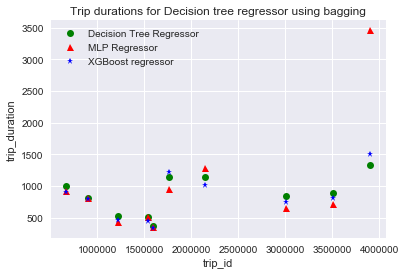

In [21]:
#compare the results for Decistion tree regressor, MLP Regressor and XFBoost regressor
results_dtrbagging = pd.read_csv('results_dtrbagging.csv')
results_dtrbagging = results_dtrbagging[:10]
results_mlp = pd.read_csv('results_mlp_final.csv')
results_mlp = results_mlp[:10]
results_xboost = pd.read_csv('results_xboost.csv')
results_xboost = results_xboost[:10]

pattern = re.compile("([a-zA-Z]+)([0-9]+)")
results_dtrbagging['id'] = [pattern.match(s).group(2) for s in results_dtrbagging['id']]
results_mlp['id'] = [pattern.match(s).group(2) for s in results_mlp['id']]
results_xboost['id'] = [pattern.match(s).group(2) for s in results_xboost['id']]

dtr, = plt.plot(results_dtrbagging['id'], results_dtrbagging['trip_duration'],'go')
mlp, = plt.plot(results_mlp['id'], results_mlp['trip_duration'],'r^')
xgb, = plt.plot(results_xboost['id'], results_xboost['trip_duration'],'b*')
plt.title('Trip durations for Decision tree regressor using bagging')
plt.legend([dtr, mlp, xgb],['Decision Tree Regressor', 'MLP Regressor','XGBoost regressor'])
plt.ylabel('trip_duration')
plt.xlabel('trip_id')
plt.show()